In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from tqdm import tqdm

%matplotlib inline

#每次可以输出多个变量
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

import warnings
warnings.filterwarnings("ignore")

#中文字体
import matplotlib
matplotlib.use('qt4agg')
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False

# XGB 历史数据

In [91]:
train = pd.read_csv('train_preprocessing34.csv')

train.shape
train.head()

(278894, 101)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,user_age_level,user_occupation_id,user_star_level,context_id,context_timestamp,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade,item_category_split,item_property_split,predict_category_property_split,item_category_split_count,item_property_split_count,time,day,hour,minute,user_query_day,user_query_day_hour,user_query_minute,user_shop_count,user_item_count,user_context_count,user_shop_trade_count,user_item_trade_count,user_context_trade_count,user_brand_count,user_city_count,user_brand_trade_count,user_city_trade_count,item_occupation_count,item_age_count,item_gender_count,item_occupation_trade_count,item_age_trade_count,item_gender_trade_count,shop_score,item_score,item_score2,item_score3,predict_category_split,predict_property_split,pred_category_split_count,pred_property_split_count,item_pred_category_score,item_pred_property_score,item_pred_category_score_item%,item_pred_property_score_item%,item_pred_category_score_pred%,item_pred_property_score_pred%,item_hot,user_hot,shop_hot,brand_hot,occupation_hot,city_hot,item_trade_hot,user_trade_hot,shop_trade_hot,brand_trade_hot,occupation_trade_hot,city_trade_hot,user_sell_power,user_sell_power_mean,user_sell_power_mean_item_minus,user_sell_trade_power,user_sell_trade_power_mean,user_sell_trade_power_mean_item_minus,yesterday,yesterhour,user_day_query,user_yesterday_query,user_hour_query,user_yesterhour_query,user_minute_query,item_day_query,item_hour_query,item_minute_query,user_item_day_query,user_item_hour_query,user_item_minute_query,min_time
0,4293715837363757697,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,4,4,14,8711326521450559534,0,1000,2005,3003,5035994110420503338,1537465939,1,5799347067982556520:9172976955054793469;725801...,6765930309048922341,4,1.000000,3,1.000000,1.000000,1.000000,0,"['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...","[['5799347067982556520', '9172976955054793469'...",2,21,2018-09-21 01:52:19,21,1,55,9,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,6.0,0.0,0.0,0.0,7.000000,60,20.000,10.000000,"['5799347067982556520', '7258015885215914736',...","['9172976955054793469', '9172976955054793469']",5,2,2,1,6.666667,0.454545,3.333333,3.333333,12.0,0.0,12.0,50.0,137467,25252.0,0.0,0.0,0.0,0.0,2611,429.0,0.0,0.0,3.0,0.0,0.0,3.0,20,0,9,0.0,1,0.0,1,1,1,1,1,1,1,3.0
1,70764105903083828,285660928590172217,7908382889764677758;8277336076276184272,2072967855524022579;5131280576272319091;263639...,9057103201734987852,548352491538518780,8,9,8,14,8064892827740019258,0,1003,2005,3003,7972645707776427108,1537537076,14,8277336076276184272:820214312075361939;5799347...,4885989684392199728,15,0.985647,13,0.974774,0.976604,0.969257,0,"['7908382889764677758', '8277336076276184272']","['2072967855524022579', '5131280576272319091',...","[['8277336076276184272', '820214312075361939']...",2,50,2018-09-21 21:37:56,21,21,35,9,8,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,13.0,22.0,1.0,1.0,1.0,25.636987,121,15.125,1.008333,"['8277336076276184272', '5799347067982556520',...",['820214312075361939'],4,1,2,1,6.666667,0.196078,4.000000,5.000000,29.0,0.0,55.0,70.0,137467,739.0,1.0,0.0,2.0,1.0,2611,11.0,0.0,0.0,8.0,0.0,0.0,8.0,20,20,9,0.0,8,0.0,5,15,3,1,1,1,1,43.0
2,3954908518456917085,5202355029344881809,7908382889764677758;5755694407684602296,2072967855524022579;5131280576272319091;263639...,5520678735822176314,548352491538518780,8,9,10,16,1633738185485564030,0,1003,2005,3003,6797298244965748241,1537539269,1,5755694407684602296:6538068079754090196;836752...,4885989684392199728,15,0.985647,13,0.974774,0.976604,0.969257

In [92]:
predictors = [
    'item_price_level', 'item_sales_level', 'item_collected_level',
    'item_pv_level', 'user_gender_id', 'user_age_level', 'user_occupation_id',
    'user_star_level', 'context_page_id', 'shop_review_num_level',
    'shop_review_positive_rate', 'shop_star_level', 'shop_score_service',
    'shop_score_delivery', 'shop_score_description',
    'item_category_split_count', 'item_property_split_count', 'day', 'hour',
    'user_query_day', 'user_query_day_hour', 'user_shop_count',
    'user_item_count', 'user_context_count', 'user_shop_trade_count',
    'user_item_trade_count', 'user_context_trade_count', 'user_brand_count',
    'user_city_count', 'user_brand_trade_count', 'user_city_trade_count',
    'item_occupation_count', 'item_age_count', 'item_gender_count',
    'item_occupation_trade_count', 'item_age_trade_count',
    'item_gender_trade_count', 'shop_score', 'item_score', 'item_score2',
    'item_score3', 'pred_category_split_count', 'pred_property_split_count',
    'item_pred_category_score', 'item_pred_property_score',
    'item_pred_category_score_item%', 'item_pred_property_score_item%',
    'item_pred_category_score_pred%', 'item_pred_property_score_pred%',
    'item_hot', 'user_hot', 'shop_hot', 'brand_hot', 'occupation_hot',
    'city_hot', 'item_trade_hot', 'user_trade_hot', 'shop_trade_hot',
    'brand_trade_hot', 'occupation_trade_hot', 'city_trade_hot',
    'user_sell_power', 'user_sell_power_mean',
    'user_sell_power_mean_item_minus', 'user_sell_trade_power',
    'user_sell_trade_power_mean', 'user_sell_trade_power_mean_item_minus',
    'yesterday', 'yesterhour', 'user_day_query', 'user_yesterday_query',
    'user_hour_query', 'user_yesterhour_query', 'minute', 'user_query_minute',
    'item_day_query', 'item_hour_query', 'user_item_day_query', 'min_time',
    'user_item_hour_query', 'item_minute_query', 'user_minute_query',
    'user_item_minute_query'
]

target = ['is_trade']

In [79]:
#one-hot
# train = pd.get_dummies(
#     train, columns=['user_gender_id', 'user_occupation_id'])

# train = train.drop(
#     [
#         'item_property_split', 'predict_category_split', 'context_timestamp',
#         'item_city_id', 'user_id', 'context_id', 'item_property_list',
#         'predict_property_split', 'item_id', 'item_category_split',
#         'instance_id', 'item_category_list', 'predict_category_property_split',
#         'time', 'predict_category_property', 'item_brand_id', 'shop_id'
#     ],
#     axis=1)

In [93]:
import sys
sys.path.append('/Users/zero/xgboost/python-package')
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.metrics import log_loss

In [94]:
test = train[train.is_trade == -1]
val = train[(train.is_trade != -1) & (train.day == 24)]
train = train[(train.is_trade != -1) & (train.day != 24)]

train.shape
val.shape
test.shape

(203112, 101)

(57411, 101)

(18371, 101)

0.0811874146126


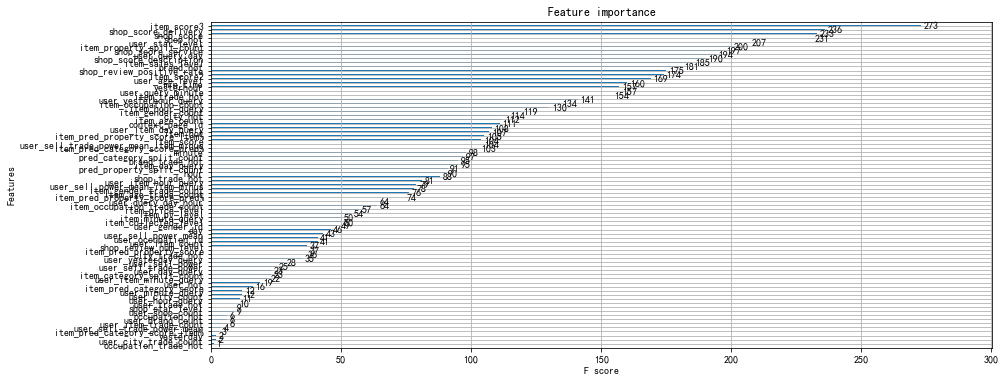

In [95]:
#train/val
params = {
    'objective': 'binary:logistic',
    'eta': 0.05,
    'colsample_bytree': 0.886,
    'min_child_weight': 0.2,
    'max_depth': 5,
    'subsample': 0.886,
    'gamma': 0.1,
    'lambda': 10,
    'verbose_eval': True,
    'eval_metric': 'auc',
    'seed': 201803,
    'missing': -1
}

xgbtrain = xgb.DMatrix(train[predictors], train[target])
xgbval = xgb.DMatrix(val[predictors])
model = xgb.train(params, xgbtrain, num_boost_round=250)
y_pred = model.predict(xgbval)
y_pred = pd.Series(y_pred, name='val')

print(log_loss(val[target], y_pred))  # 0.0811874146126(3:4)
xgb.plot_importance(model)

In [49]:
# 0.0816262372061(3:4)：87
params = {
    'objective': 'binary:logistic',
    'eta': 0.07,
    'colsample_bytree': 0.886,
    'min_child_weight': 0.1,
    'max_depth': 5,
    'subsample': 0.886,
    'gamma': 0.1,
    'lambda': 10,
    'verbose_eval': True,
    'eval_metric': 'auc',
    'seed': 201803,
    'missing': -1
} * 210
# 0.0812110466927(3:4)：101
params = {
    'objective': 'binary:logistic',
    'eta': 0.05,
    'colsample_bytree': 0.886,
    'min_child_weight': 0.2,
    'max_depth': 5,
    'subsample': 0.886,
    'gamma': 0.1,
    'lambda': 10,
    'verbose_eval': True,
    'eval_metric': 'auc',
    'seed': 201803,
    'missing': -1
} * 250

0.0819624602198


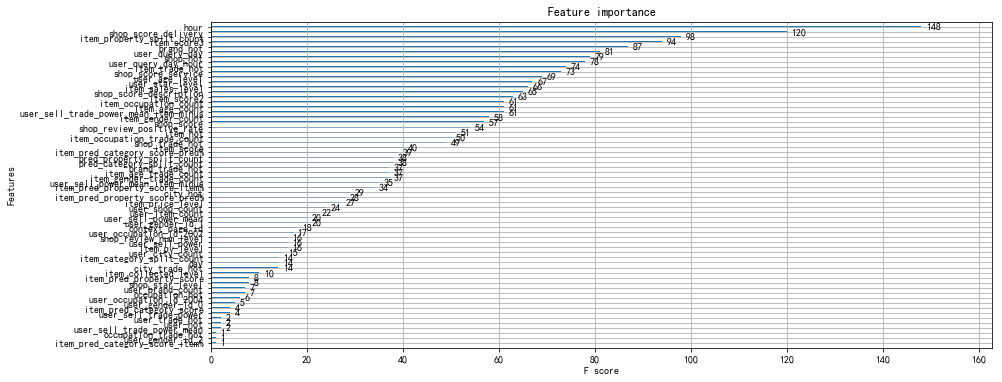

In [93]:
#train/val
params = {
    'objective': 'binary:logistic',
    'eta': 0.1,
    'colsample_bytree': 0.886,
    'min_child_weight': 1,
    'max_depth': 5,
    'subsample': 0.886,
    'gamma': 0.1,
    'lambda': 10,
    'verbose_eval': True,
    'eval_metric': 'auc',
    'seed': 201803,
    'missing': -1
}

xgbtrain = xgb.DMatrix(train.drop(['is_trade'], axis=1), train.is_trade)
xgbval = xgb.DMatrix(val.drop(['is_trade'], axis=1))
model = xgb.train(params, xgbtrain, num_boost_round=100)
y_pred = model.predict(xgbval)
y_pred = pd.Series(y_pred, name='val')

print(log_loss(val[target], y_pred))  # 0.0817455631392(4:3)
xgb.plot_importance(model)

#user_gender_id和user_occupation_id One-Hot了之后反而升到了0.0819624602198？！

# XGB 无历史数据

In [96]:
df = pd.read_csv('df_without_his.csv')

df.shape
df.head()

(496509, 68)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,user_age_level,user_occupation_id,user_star_level,context_id,context_timestamp,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade,time,day,hour,user_query_day,user_query_day_hour,shop_score,item_score,item_score2,item_score3,predict_category_property_split,predict_category_split,predict_property_split,item_category_split,item_property_split,item_category_split_count,item_property_split_count,predict_category_property_split_count,pred_category_split_count,pred_property_split_count,item_pred_category_score,item_pred_property_score,item_pred_category_score_item%,item_pred_property_score_item%,item_pred_category_score_pred%,item_pred_property_score_pred%,yesterday,yesterhour,user_day_query,user_yesterday_query,user_hour_query,user_yesterhour_query,minute,user_query_minute,item_day_query,item_hour_query,user_item_day_query,min_time,user_item_hour_query,user_minute_query,item_minute_query,user_item_minute_query
0,108641074714126964,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,4505772604969228686,1,1003,2005,3003,282924576738839389,1537236544,5,5799347067982556520:-1;509660095530134768:-1;5...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 10:09:04,18,10,3,3,7.0,59,19.666667,3.277778,"['5799347067982556520:-1', '509660095530134768...","['5799347067982556520', '509660095530134768', ...",['9148482949976129397'],"['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,5,5,1,2,0,6.666667,0.000000,3.333333,0.000000,17,9,3,0.0,3,0.0,5,1,6,2,1,20.0,1,1,1,1
1,5754713551599725161,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2692638157208937547,0,1002,2005,3006,4007979028023783431,1537243232,0,5799347067982556520:9172976955054793469;790838...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 12:00:32,18,12,8,5,7.0,59,19.666667,19.666667,"['5799347067982556520:9172976955054793469', '7...","['5799347067982556520', '7908382889764677758']","['9172976955054793469', '1787573075717641245,9...","['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,2,2,2,2,1,6.666667,0.434783,6.666667,3.333333,17,11,8,0.0,5,1.0,5,4,6,1,1,24.0,1,4,1,1
2,842679481291040981,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,5247924392014515924,0,1003,2005,3004,4884875192608989870,1537211052,0,5799347067982556520:5131280576272319091;725801...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 03:04:12,18,3,2,2,7.0,59,19.666667,19.666667,"['5799347067982556520:5131280576272319091', '7...","['5799347067982556520', '7258015885215914736',...","['5131280576272319091', '5131280576272319091',...","['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,3,3,3,2,1,6.666667,0.434783,5.000000,2.500000,17,2,2,0.0,2,0.0,5,2,6,2,1,6.0,1,2,1,1
3,937088850059189027,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2681414445369714628,1,1004,2005,3006,840119421106178602,1537222670,15,509660095530134768:-1;5799347067982556520:-1;7...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 06:17:50,18,6,1,1,7.0,59,19.666667,1.229167,"['509660095530134768:-1', '5799347067982556520...","['509660095530134768', '5799347067982556520', ...","['1787573075717641245,9148482949976129397', '9...","['79083

In [97]:
predictors = [
    'item_price_level', 'item_sales_level', 'item_collected_level',
    'item_pv_level', 'user_gender_id', 'user_age_level', 'user_occupation_id',
    'user_star_level', 'context_page_id', 'shop_review_num_level',
    'shop_review_positive_rate', 'shop_star_level', 'shop_score_service',
    'shop_score_delivery', 'shop_score_description', 'day', 'hour',
    'user_query_day', 'user_query_day_hour', 'shop_score', 'item_score',
    'item_score2', 'item_score3', 'item_category_split_count',
    'item_property_split_count', 'pred_category_split_count',
    'pred_property_split_count', 'item_pred_category_score',
    'item_pred_property_score', 'item_pred_category_score_item%',
    'item_pred_property_score_item%', 'item_pred_category_score_pred%',
    'item_pred_property_score_pred%', 'yesterday', 'yesterhour',
    'user_day_query', 'user_yesterday_query', 'user_hour_query',
    'user_yesterhour_query', 'minute', 'user_query_minute', 'item_day_query',
    'item_hour_query', 'user_item_day_query', 'min_time',
    'user_item_hour_query', 'user_item_minute_query', 'item_minute_query',
    'user_minute_query'
]

target = ['is_trade']

In [98]:
y_train = df[(df.day != 24) & (df.is_trade != -1)][target]
x_train = df[(df.day != 24) & (df.is_trade != -1)][predictors]

y_val = df[(df.day == 24) & (df.is_trade != -1)][target]
x_val = df[(df.day == 24) & (df.is_trade != -1)][predictors]

y_test = df[df.is_trade == -1][target]
x_test = df[df.is_trade == -1][predictors]
idx = df[df.is_trade == -1].instance_id.reset_index()

x_train.shape
x_val.shape
x_test.shape

del df

#(420717, 33)
#(57421, 33)
#(18371, 33)

(420717, 49)

(57421, 49)

(18371, 49)

In [99]:
import sys
sys.path.append('/Users/zero/xgboost/python-package')
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.metrics import log_loss

0.0813534669374


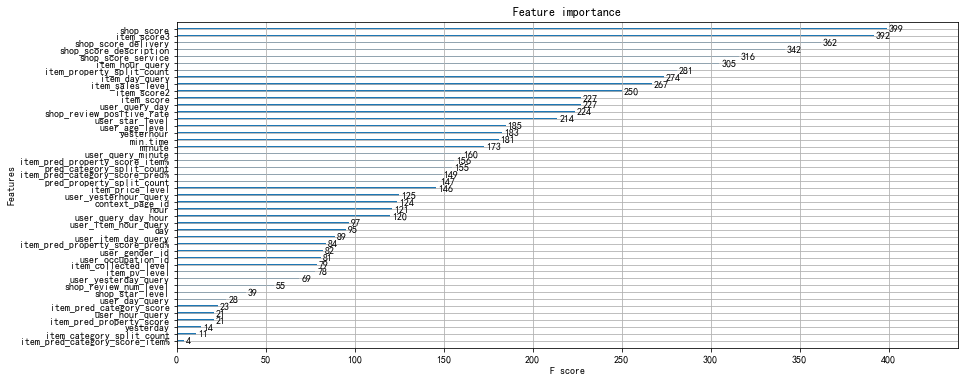

In [43]:
params = {
    'objective': 'binary:logistic',
    'eta': 0.1,
    'colsample_bytree': 0.886,
    'min_child_weight': 0.1,
    'max_depth': 5,
    'subsample': 0.886,
    'gamma': 0.1,
    'lambda': 10,
    'verbose_eval': True,
    'eval_metric': 'auc',
    #     'scale_pos_weight': 50,
    'seed': 201803,
    'missing': -1
}

xgbtrain = xgb.DMatrix(x_train, y_train)
xgbval = xgb.DMatrix(x_val)
model = xgb.train(params, xgbtrain, num_boost_round=250)
y_pred = model.predict(xgbval)
y_pred = pd.Series(y_pred, name='val')

print(log_loss(y_val, y_pred))  # 0.0813534669374(46 Features)
xgb.plot_importance(model)

xgbtest = xgb.DMatrix(x_test)
y_pred = model.predict(xgbtest)

idx['predicted_score'] = y_pred
idx[['instance_id', 'predicted_score']].to_csv(
    'resultWithoutHistory.txt',
    sep=' ',
    header=['instance_id', 'predicted_score'],
    index=False)

In [ ]:
#33 Features(0.0816401133236/0.08293 )
#46 Features(0.0813534669374/0.08265)

# lgb试一下

In [35]:
import lightgbm as lgb
from sklearn.metrics import log_loss
import gc

In [138]:
df = pd.read_csv('df_without_his.csv')

df.shape
df.head()

(496509, 52)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,user_age_level,user_occupation_id,user_star_level,context_id,context_timestamp,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade,time,day,hour,user_query_day,user_query_day_hour,shop_score,item_score,item_score2,item_score3,predict_category_property_split,predict_category_split,predict_property_split,item_category_split,item_property_split,item_category_split_count,item_property_split_count,predict_category_property_split_count,pred_category_split_count,pred_property_split_count,item_pred_category_score,item_pred_property_score,item_pred_category_score_item%,item_pred_property_score_item%,item_pred_category_score_pred%,item_pred_property_score_pred%
0,108641074714126964,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,4505772604969228686,1,1003,2005,3003,282924576738839389,1537236544,5,5799347067982556520:-1;509660095530134768:-1;5...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 10:09:04,18,10,3,3,7.0,59,19.666667,3.277778,"['5799347067982556520:-1', '509660095530134768...","['5799347067982556520', '509660095530134768', ...",['9148482949976129397'],"['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,5,5,1,2,0,6.666667,0.000000,3.333333,0.000000
1,5754713551599725161,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2692638157208937547,0,1002,2005,3006,4007979028023783431,1537243232,0,5799347067982556520:9172976955054793469;790838...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 12:00:32,18,12,8,5,7.0,59,19.666667,19.666667,"['5799347067982556520:9172976955054793469', '7...","['5799347067982556520', '7908382889764677758']","['9172976955054793469', '1787573075717641245,9...","['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,2,2,2,2,1,6.666667,0.434783,6.666667,3.333333
2,842679481291040981,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,5247924392014515924,0,1003,2005,3004,4884875192608989870,1537211052,0,5799347067982556520:5131280576272319091;725801...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 03:04:12,18,3,2,2,7.0,59,19.666667,19.666667,"['5799347067982556520:5131280576272319091', '7...","['5799347067982556520', '7258015885215914736',...","['5131280576272319091', '5131280576272319091',...","['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,3,3,3,2,1,6.666667,0.434783,5.000000,2.500000
3,937088850059189027,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2681414445369714628,1,1004,2005,3006,840119421106178602,1537222670,15,509660095530134768:-1;5799347067982556520:-1;7...,6765930309048922341,4,1.0,3,1.0,1.0,1.0,0,2018-09-18 06:17:50,18,6,1,1,7.0,59,19.666667,1.229167,"['509660095530134768:-1', '5799347067982556520...","['509660095530134768', '5799347067982556520', ...","['1787573075717641245,9148482949976129397', '9...","['7908382889764677758', '5799347067982556520']","['2072967855524022579', '5131280576272319091',...",2,22,5,5,3,2,0,6.666667,0.000000,3.333333,0.000000
4,7975697065017708072,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2729475788342039013,0,1002,2005,3001,173676997171035468

In [139]:
y_train = df[(df.day != 24) & (df.is_trade != -1)][target]
x_train = df[(df.day != 24) & (df.is_trade != -1)][predictors]

y_val = df[(df.day == 24) & (df.is_trade != -1)][target]
x_val = df[(df.day == 24) & (df.is_trade != -1)][predictors]

y_test = df[df.is_trade == -1][target]
x_test = df[df.is_trade == -1][predictors]

x_train.shape
x_val.shape
x_test.shape

del df

(420717, 33)

(57421, 33)

(18371, 33)

In [122]:
#without history
clf = lgb.LGBMClassifier(
    learning_rate=0.07,
    colsample_bytree=1.0,
    num_leaves=50,
    max_depth=5,
    min_child_weight=0.1,
    n_estimators=400,
    n_jobs=20,
    reg_alpha=0.1,
    reg_lambda=0.1)
clf.fit(
    x_train,
    y_train,
    feature_name=predictors,
    categorical_feature=['user_gender_id', 'user_occupation_id'])
y_pred = clf.predict_proba(x_val)[:, 1]
print(log_loss(y_val, y_pred))  # 0.0817086630893
lgb.plot_importance(clf)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.07, max_depth=5, min_child_samples=20,
        min_child_weight=0.1, min_split_gain=0.0, n_estimators=400,
        n_jobs=20, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

0.081978292469


In [98]:
train = pd.read_csv('train_preprocessing52.csv')

train.shape
train.head()

(139406, 85)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,user_age_level,user_occupation_id,user_star_level,context_id,context_timestamp,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade,item_category_split,item_property_split,predict_category_property_split,item_category_split_count,item_property_split_count,time,day,hour,user_query_day,user_query_day_hour,user_shop_count,user_item_count,user_context_count,user_shop_trade_count,user_item_trade_count,user_context_trade_count,user_brand_count,user_city_count,user_brand_trade_count,user_city_trade_count,item_occupation_count,item_age_count,item_gender_count,item_occupation_trade_count,item_age_trade_count,item_gender_trade_count,shop_score,item_score,item_score2,item_score3,predict_category_split,predict_property_split,pred_category_split_count,pred_property_split_count,item_pred_category_score,item_pred_property_score,item_pred_category_score_item%,item_pred_property_score_item%,item_pred_category_score_pred%,item_pred_property_score_pred%,item_hot,user_hot,shop_hot,brand_hot,occupation_hot,city_hot,item_trade_hot,user_trade_hot,shop_trade_hot,brand_trade_hot,occupation_trade_hot,city_trade_hot,user_sell_power,user_sell_power_mean,user_sell_power_mean_item_minus,user_sell_trade_power,user_sell_trade_power_mean,user_sell_trade_power_mean_item_minus
0,1294180558417909525,3417228998968466891,7908382889764677758;5799347067982556520,2636395404473730413;4067341101015777832;101341...,1369755222868145421,5326000431362991708,7,1,4,8,4790424684324799775,0,1003,2002,3006,8843409125615638650,1537712904,0,"5799347067982556520:9172976955054793469,742282...",3011322251466986596,12,0.981125,10,0.974849,0.977525,0.966823,0,"['7908382889764677758', '5799347067982556520']","['2636395404473730413', '4067341101015777832',...","[['5799347067982556520', '9172976955054793469,...",2,14,2018-09-23 22:28:24,23,22,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,20.060442,33,4.714286,4.714286,"['5799347067982556520', '7908382889764677758']","['9172976955054793469,7422828355050797095', '7...",2,2,2,0,6.666667,0.0,6.666667,0.0,1.0,18.0,1.0,1.0,110154,1274,0.0,0.0,0.0,0.0,2306,35,111.0,5.842105,1.157895,0.0,0.0,7.0
1,4988669284857152533,932459418921071956,7908382889764677758;5755694407684602296,5131280576272319091;2636395404473730413;655689...,3101174666276603352,7322157373578955368,8,12,14,18,5297018676355586708,1,1004,2002,3005,5448626819385615379,1537703526,0,5755694407684602296:-1;7908382889764677758:-1;...,6244933171089048032,16,1.000000,15,0.963192,0.960966,0.983802,0,"['7908382889764677758', '5755694407684602296']","['5131280576272319091', '2636395404473730413',...","[['5755694407684602296', '-1'], ['790838288976...",2,49,2018-09-23 19:52:06,23,19,3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,79.0,84.0,3.0,3.0,3.0,28.228659,264,33.000000,33.000000,"['5755694407684602296', '7908382889764677758',...",[],4,0,2,0,6.666667,0.0,4.000000,0.0,292.0,0.0,375.0,645.0,110154,43204,7.0,0.0,8.0,17.0,2306,912,0.0,0.000000,8.000000,0.0,0.0,8.0
2,5378282568284173939,932459418921071956,7908382889764677758;5755694407684602296,5131280576272319091;2636395404473730413;655689...,3101174666276603352,7322157373578955368,8,12,14,18,2128349640379796295,0,1005,2005,3002,6454805461923703549,1537699469,0,2948160913626618607:4083958765544089731;264834...,6244933171089048032,16,1.000000,15,0.963192,0.960966,0.983802,0,"['7908382889764677758', '5755694407684602296']","['5131280576272319091', '2636395404473730413',...","[['2948160913626618607', '4083958765544089731'...",2,49,2018-09-23 18:44:29,23,18,4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.0,48.0,193.0,4.0,1.0,4.0,28.228659,264,33.000000,33.000000,"['2948160913626618607', '2648343924459474923',...","['408

In [99]:
test = train[train.is_trade == -1]
val = train[(train.is_trade != -1) & (train.day == 24)]
train = train[(train.is_trade != -1) & (train.day == 23)]

train.shape
val.shape
test.shape

(63614, 85)

(57421, 85)

(18371, 85)

In [100]:
predictors = [
    'item_price_level', 'item_sales_level', 'item_collected_level',
    'item_pv_level', 'user_gender_id', 'user_age_level', 'user_occupation_id',
    'user_star_level', 'context_page_id', 'shop_review_num_level',
    'shop_review_positive_rate', 'shop_star_level', 'shop_score_service',
    'shop_score_delivery', 'shop_score_description',
    'item_category_split_count', 'item_property_split_count', 'day', 'hour',
    'user_query_day', 'user_query_day_hour', 'user_shop_count',
    'user_item_count', 'user_context_count', 'user_shop_trade_count',
    'user_item_trade_count', 'user_context_trade_count', 'user_brand_count',
    'user_city_count', 'user_brand_trade_count', 'user_city_trade_count',
    'item_occupation_count', 'item_age_count', 'item_gender_count',
    'item_occupation_trade_count', 'item_age_trade_count',
    'item_gender_trade_count', 'shop_score', 'item_score', 'item_score2',
    'item_score3', 'pred_category_split_count', 'pred_property_split_count',
    'item_pred_category_score', 'item_pred_property_score',
    'item_pred_category_score_item%', 'item_pred_property_score_item%',
    'item_pred_category_score_pred%', 'item_pred_property_score_pred%',
    'item_hot', 'user_hot', 'shop_hot', 'brand_hot', 'occupation_hot',
    'city_hot', 'item_trade_hot', 'user_trade_hot', 'shop_trade_hot',
    'brand_trade_hot', 'occupation_trade_hot', 'city_trade_hot',
    'user_sell_power', 'user_sell_power_mean',
    'user_sell_power_mean_item_minus', 'user_sell_trade_power',
    'user_sell_trade_power_mean', 'user_sell_trade_power_mean_item_minus'
]

target = ['is_trade']

In [109]:
#val
clf = lgb.LGBMClassifier(
    learning_rate=0.05,
    num_leaves=63,
    max_depth=5,
    min_child_weight=0.1,
    n_estimators=112,
    n_jobs=20,
    reg_alpha=0.1,
    reg_lambda=0.1)
clf.fit(
    train[predictors],
    train[target],
    feature_name=predictors,
    categorical_feature=['user_gender_id', 'user_occupation_id', 'day'])
y_val = clf.predict_proba(val[predictors])[:, 1]
print(log_loss(val[target], y_val))  # 0.0824696179375
lgb.plot_importance(clf)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.05, max_depth=5, min_child_samples=20,
        min_child_weight=0.1, min_split_gain=0.0, n_estimators=112,
        n_jobs=20, num_leaves=63, objective=None, random_state=None,
        reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

0.0825322791568


In [90]:
#test
train = pd.concat([train, val])

clf = lgb.LGBMClassifier(
    learning_rate=0.05,
    num_leaves=63,
    max_depth=5,
    min_child_weight=0.1,
    n_estimators=112,
    n_jobs=20,
    reg_alpha=0.1,
    reg_lambda=0.1)
clf.fit(
    train[predictors],
    train[target],
    feature_name=predictors,
    categorical_feature=['user_gender_id', 'user_occupation_id', 'day'])
y_pred = clf.predict_proba(test[predictors])[:, 1]
test['predicted_score'] = y_pred

test[['instance_id', 'predicted_score']].to_csv(
    'resultWithHistory.txt',
    sep=' ',
    header=['instance_id', 'predicted_score'],
    index=None)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.05, max_depth=5, min_child_samples=20,
        min_child_weight=0.1, min_split_gain=0.0, n_estimators=112,
        n_jobs=20, num_leaves=63, objective=None, random_state=None,
        reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)